In [1]:
# Imports
import tensorflow as tf
import glob
import os
import matplotlib.pyplot as plt


# Set to TF to GPU
devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(devices[0], True)

In [2]:
#Set up directories for dataset (These were retrived from C: on my own PC)

# Test
test_directory = sorted(glob.glob(r"C:\Users\paiwa\Desktop\Uni\Sem 2 2020\COMP3710\keras_png_slices_data\keras_png_slices_test\*.png"))

# Train
train_directory = sorted(glob.glob(r"C:\Users\paiwa\Desktop\Uni\Sem 2 2020\COMP3710\keras_png_slices_data\keras_png_slices_train\*.png"))

In [3]:
train = tf.data.Dataset.from_tensor_slices(train_directory)
test = tf.data.Dataset.from_tensor_slices(test_directory)

train = train.shuffle(len(train_directory))
test = test.shuffle(len(test_directory))

In [4]:
# Pre processing and image displaying functions

# Map function

def pre_processing(input):
    
    # Read/output contents of filename
    data = tf.io.read_file(input)
    
    # Convert images to grayscale
    data = tf.image.decode_png(data, channels = 1)
    
    # Resize to 256*256
    data = tf.image.resize(data, (256,256))
    
    # Normalise to (-1,1)
    data = tf.cast(data, tf.float32) - 127.5
    data = data / 127.5
    
    return data

# Function to map datasets and set batch sizes

def map_and_batch(input, map_func, batch_size):
    
    input = input.map(map_func).batch(batch_size)
    
    return input


# Functions to display images


# Process single

def show_image(input):
    
    # Configure output figure's dpi and size
    output = plt.figure(dpi = 300, figsize = (4,4))
    
    # Iterate over input to display
    input_range = range(len(input))
    for i in input_range:
        plt.subplot(4,4, i + 1)
        for j in range(16):
            plt.axis("off")
            plt.imshow(input[i], cmap = "gray")
            
    plt.show()
    

# Process multiple

def show_images(input):
    
    # Iterate over a batch of images
    for image in input:
        show_image([tf.squeeze(image)][0])

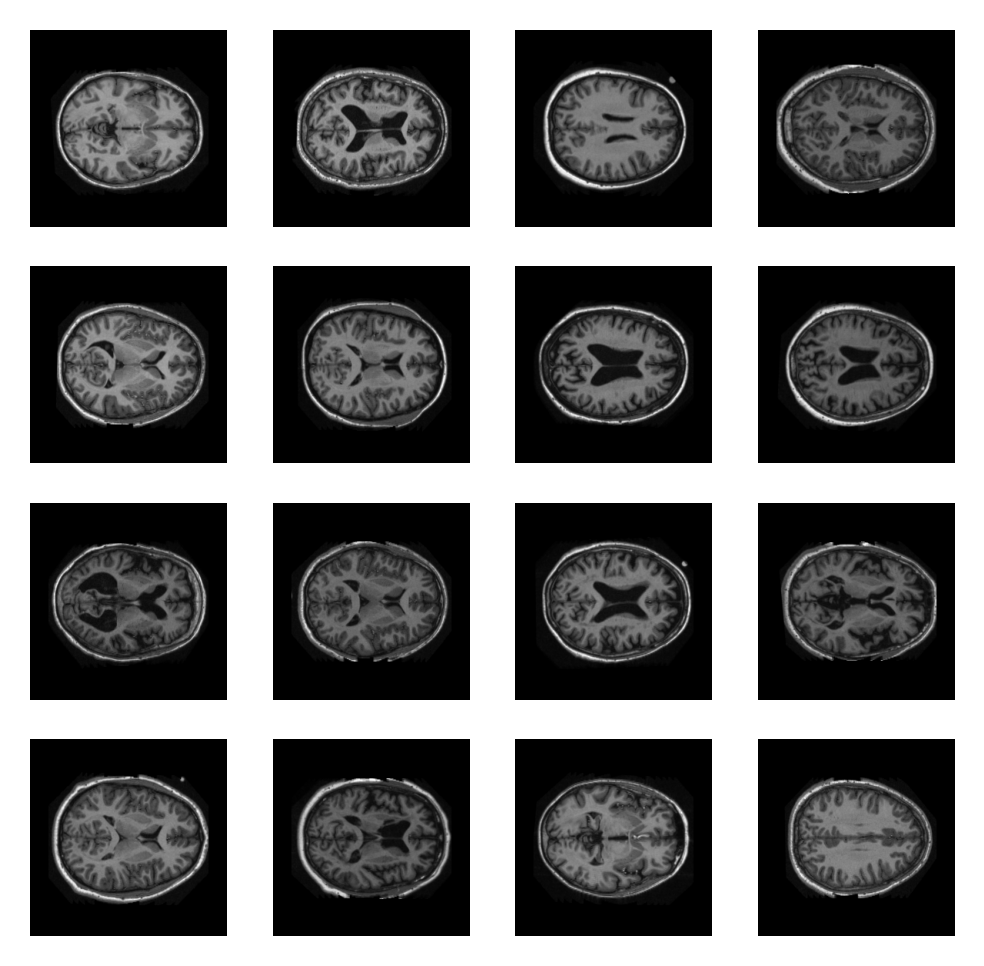

In [5]:
# Apply pre-processing functions to the data

test_data = map_and_batch(test, pre_processing, 16)
train_data = map_and_batch(train, pre_processing, 16)


# Display one batch after processing to see 
# if data processing has been successful

show_images(train_data.take(1))

In [6]:
# Importing layers for models

from tensorflow.keras.layers import Conv2D 
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import LeakyReLU 
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Input

# Importing optimiser

from tensorflow.keras.optimizers import Adam

# Setting constants for models

kernel_size = (3,3)
strides = (2,2)
padding = 'same'

# Creating the discriminator. 

# In the discriminator we downsample to a single number scalar output
# Adapted from https://www.tensorflow.org/tutorials/generative/dcgan

def discriminator():
    model = tf.keras.Sequential();
    
    model.add(Conv2D(64, kernel_size, strides = strides, padding = padding,  input_shape = [256,256,1]))
    model.add(LeakyReLU())
    model.add(Dropout(0.4))
    
    model.add(Conv2D(128, kernel_size, strides = strides, padding = padding))
    model.add(LeakyReLU())
    model.add(Dropout(0.2))

    model.add(Conv2D(256, kernel_size, strides = strides, padding = padding))
    model.add(LeakyReLU())
    model.add(Dropout(0.2))

    model.add(Flatten())
    model.add(Dense(1)) # Loss function is binary crossentropy which has sigmoid activation thus no need for sigmoid here
    
    return model

# Creating the generator 

# In the generator we upsample to a 256*256 image
# Adapted from https://www.tensorflow.org/tutorials/generative/dcgan

def generator():
    
    model = tf.keras.Sequential()
    
    model.add(Dense(256 // 8 * 256 // 8 * 256, use_bias = False, input_shape = (100,)))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    model.add(Reshape((256 // 8, 256 // 8, 256)))

    
    model.add(Conv2DTranspose(128, kernel_size, strides = strides, padding = padding, use_bias = False))
    model.add(BatchNormalization())
    model.add(LeakyReLU())

            
    model.add(Conv2DTranspose(64, kernel_size, strides = strides, padding = padding, use_bias = False))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    
    model.add(Conv2DTranspose(1, kernel_size, strides = strides, padding = padding, use_bias = False, activation = 'tanh'))
    
    return model

In [7]:
generator = generator()
discriminator = discriminator()

In [8]:
# Loss & SSIM

seed = tf.random.normal([16, 100])

opt_g = tf.keras.optimizers.Adam(1e-4)
opt_d = tf.keras.optimizers.Adam(1e-4)

from tensorflow.keras.losses import BinaryCrossentropy

# Binary crossentropy for both generator and discriminator
entropy = BinaryCrossentropy(from_logits=True) # True as contains tensor to be fed will be probabilities [0,1]


# Loss function

def loss_func(real, fake, part):

    if part == "g":
        loss_fake = entropy(tf.ones_like(fake), fake)
        return loss_fake
    
        
    if part == "d":
        loss_real = entropy(tf.ones_like(real), real)
        loss_fake = entropy(tf.zeros_like(fake), fake)
        total = loss_real + loss_fake
        return total
    
    else:
        print("Unspecified")
        return None
    
# Graphing loss

def loss_graph(discriminator, generator):
    
        
    plt.plot(discriminator)
    plt.plot(generator)
    
    plt.title("Loss per Epoch for DCGAN")
    plt.ylabel("Loss")
    plt.xlabel("Number of epochs ran")
    plt.legend(["discriminator", "generator"], loc = "upper left")

    plt.show()
    
#SSIM
take = train_data.take(50)
images = tf.convert_to_tensor(list(take.as_numpy_iterator()))
    
def ssim(generator):
    ssim_count = []
    generated = generator(seed, training=False)
    
    for i in range(len(images)):
        ssim_count.append(tf.image.ssim(generated, images[i], max_val = 2))
    
    return tf.math.reduce_max(ssim_count).numpy()

def SSIM_graph(data):
    
    if display:
        plt.plot(data)
        plt.title("SSIM of Image vs Training Per Epoch")
        plt.ylabel('SSIM')
        plt.xlabel('Epoch')
        plt.show()

        


In [9]:
# Adapted from https://www.tensorflow.org/tutorials/generative/dcgan

def generate_images(model, epoch, test_input):
    

    inference_model = model(test_input, training=False)

    fig = plt.figure(figsize=(4,4), dpi = 300)

    for i in range(inference_model.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(inference_model[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
        plt.axis('off')

    plt.savefig('Images at Each Epoch/image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()
    

In [10]:
# Adapted from https://www.tensorflow.org/tutorials/generative/dcgan


generator_past = tf.Variable(0.00)
discriminator_past = tf.Variable(0.00)

# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(batch):
    
    noise = tf.random.normal([16, 100])
    
    with tf.GradientTape() as g_tape, tf.GradientTape() as d_tape:
        generated = generator(noise, training=True)

        real = discriminator(batch, training=True)
        fake = discriminator(generated, training=True)

        generator_loss = loss_func(real, fake, "g")
        discriminator_loss = loss_func(real, fake, "d")
        
    gradients_g = g_tape.gradient(generator_loss, generator.trainable_variables)
    gradients_d = d_tape.gradient(discriminator_loss, discriminator.trainable_variables)
    
    generator_past.assign(generator_loss)
    discriminator_past.assign(discriminator_loss)
    
    opt_g.apply_gradients(zip(gradients_g, generator.trainable_variables))
    opt_d.apply_gradients(zip(gradients_d, discriminator.trainable_variables))

In [11]:
import time 
from IPython import display

gen_loss = list()
disc_loss = list()
ssim_list = list()
    

def train_model(dataset, epochs):

    for epoch in range(epochs):
        start = time.time()
        
        for batch in dataset:
            train_step(batch)
        
        display.clear_output(wait=True)
        generate_images(generator, epoch + 1, seed)
        
        gen_loss.append(generator_past.numpy())
        disc_loss.append(discriminator_past.numpy())
        ssim_list.append(ssim(generator))
        loss_graph(disc_loss, gen_loss)

        print("Current Epoch: ", epoch + 1)
        print("Last Gen Loss, Disc Loss, SSIM: ", gen_loss[-1], disc_loss[-1], ssim_list[-1])
        print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

    # Generate after final epoch
    loss_graph(disc_loss, gen_loss)
    generate_images(generator, epochs, seed)
    SSIM_graph(ssim_list)
    
    

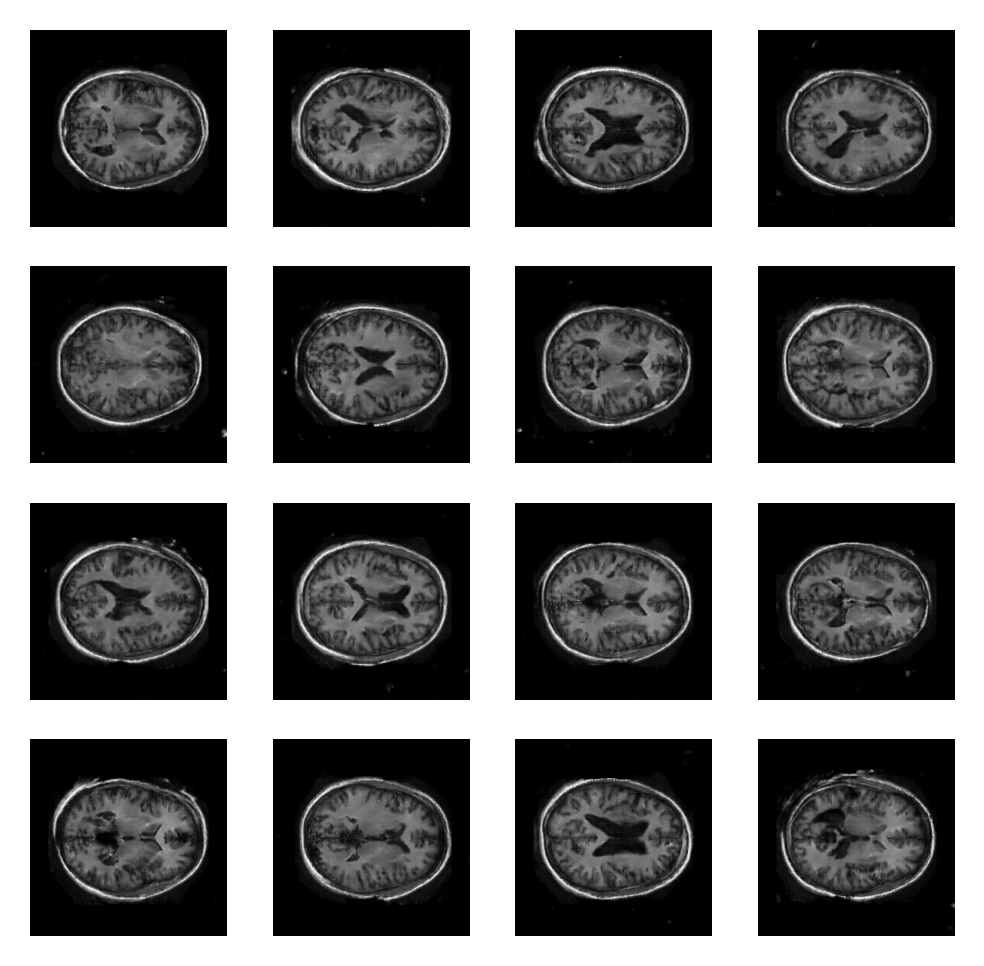

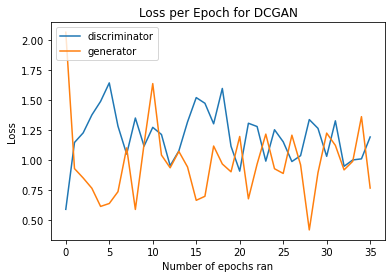

Current Epoch:  36
Last Gen Loss, Disc Loss, SSIM:  0.76832867 1.1925735 0.6687942
Time for epoch 36 is 88.79687881469727 sec


In [ ]:
train_model(train_data, 50)

In [ ]:
#Create GIF
import imageio

def gif():
    gif_images = []
    files = glob.glob(r"C:\Users\paiwa\Desktop\Uni\Sem 2 2020\COMP3710\Final Report\PatternFlow\recognition\s4537069-DCGAN-OASIS\Images at Each Epoch\*.png")    
    for file in files:
        gif_images.append(imageio.imread(filename))
    imageio.mimsave('model.gif', gif_images)

gif()